#**1. Eksplorasi Data**

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*partition.*mask.*")
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=Warning)

##**1.1 Load Data**

In [10]:
df = pd.read_csv('/content/ESP32 DataLogging_SIC5_34.csv')

##**1.2 Informasi Umum Dataset**

###**a. Informasi Tipe Data**

In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66628 entries, 0 to 66627
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date and Time  66628 non-null  object 
 1   Humidity       66628 non-null  int64  
 2   Temperature    66628 non-null  float64
 3   CO2            66628 non-null  float64
 4   CO             66628 non-null  float64
 5   PM2.5 Density  66628 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 3.1+ MB
None


###**b. Pemeriksaan Missing Values**

In [12]:
if df.isnull().sum().sum() > 0:
    df = df.dropna()

df = df[(df != 0).all(axis=1)]

print(df.isnull().sum())

Date and Time    0
Humidity         0
Temperature      0
CO2              0
CO               0
PM2.5 Density    0
dtype: int64


###**c. Pemeriksaan Data Duplikat**

In [13]:
print(f"Jumlah data duplikat: {df.duplicated().sum()}")

Jumlah data duplikat: 0


###**d. Beberapa Baris Pertama Datasets**

In [14]:
print(df.head())

         Date and Time  Humidity  Temperature       CO2      CO  PM2.5 Density
0  2024-07-03 22:20:12        80         31.3  320.7287  0.2814        23.5440
1  2024-07-03 22:20:32        80         30.8  322.3603  0.2834        12.7967
2  2024-07-03 22:20:52        80         30.8  317.3616  0.2774        40.3489
3  2024-07-03 22:21:12        80         30.8  315.5813  0.2753         7.5208
4  2024-07-03 22:21:32        80         30.8  313.0817  0.2724        22.1762


###**e. Statistik Deskriptif**

In [15]:
print(df.describe())

           Humidity   Temperature           CO2            CO  PM2.5 Density
count  66359.000000  66359.000000  66359.000000  66359.000000   66359.000000
mean      72.488283     31.485241    777.210663      1.053639      76.661999
std        5.517133      1.691528    652.276420      2.362110      86.799519
min       53.000000     25.800000    171.857400      0.119600       0.095400
25%       69.000000     30.800000    503.372950      0.522100      49.923700
50%       73.000000     31.800000    669.094900      0.771300      60.084800
75%       77.000000     32.800000    892.818350      1.145700      68.389500
max       88.000000     35.200000  30546.332000    159.764300     800.084000


##**1.3 Visualisasi Data**

###**a. Distribusi Data**

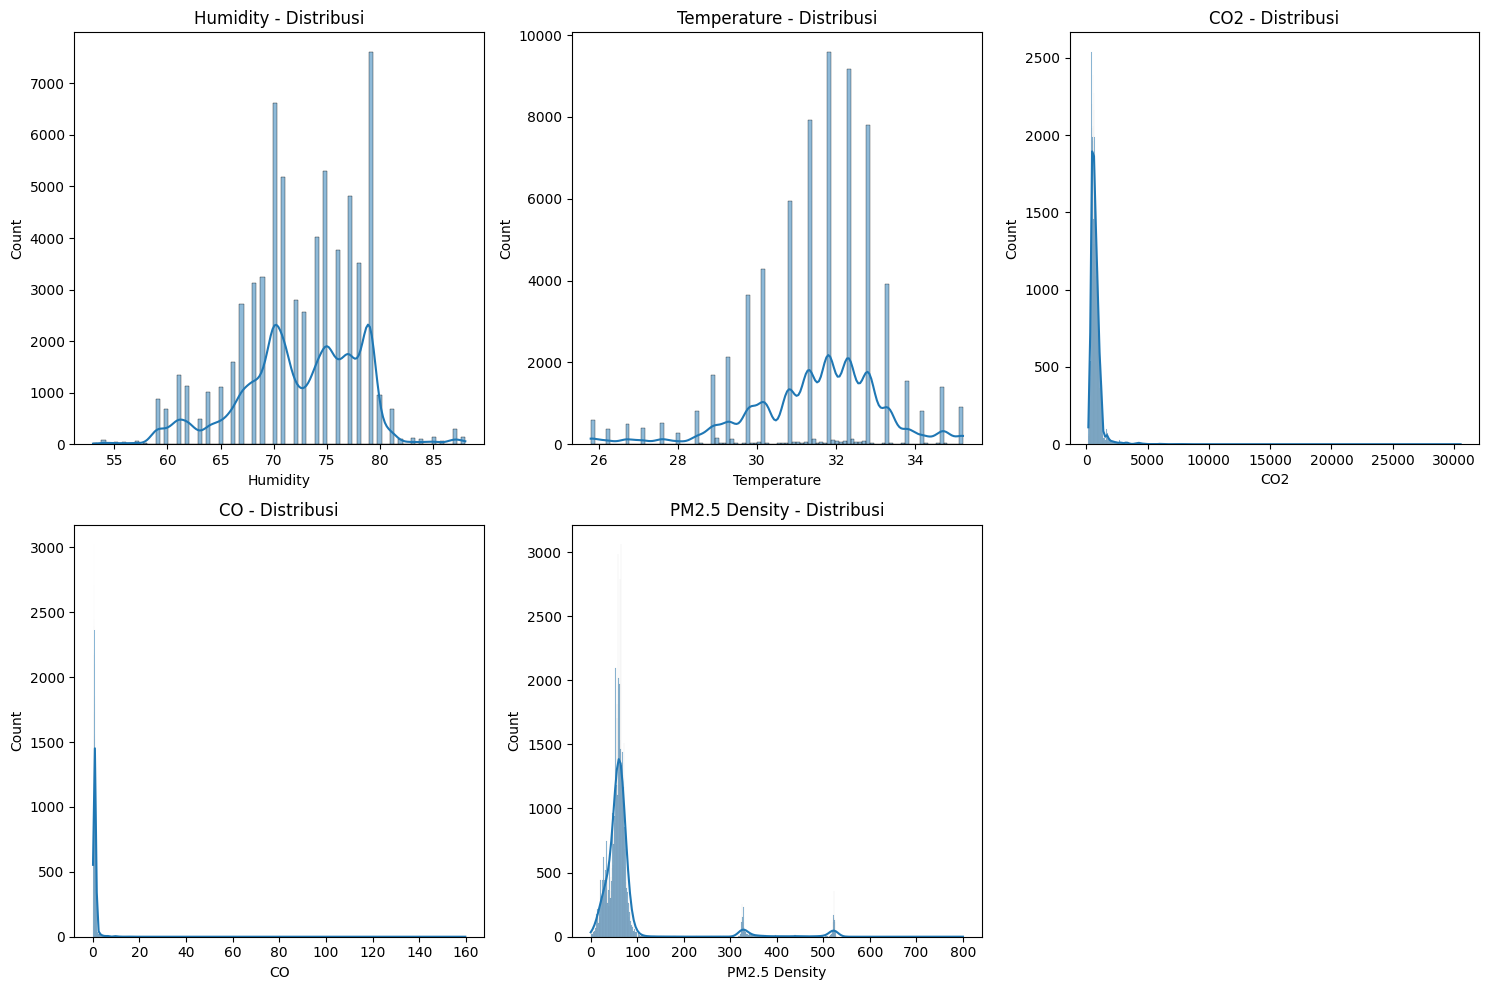

In [16]:
features = ['Humidity', 'Temperature', 'CO2', 'CO', 'PM2.5 Density']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'{feature} - Distribusi')
plt.tight_layout()
plt.show()

###**b. Data Temporal**

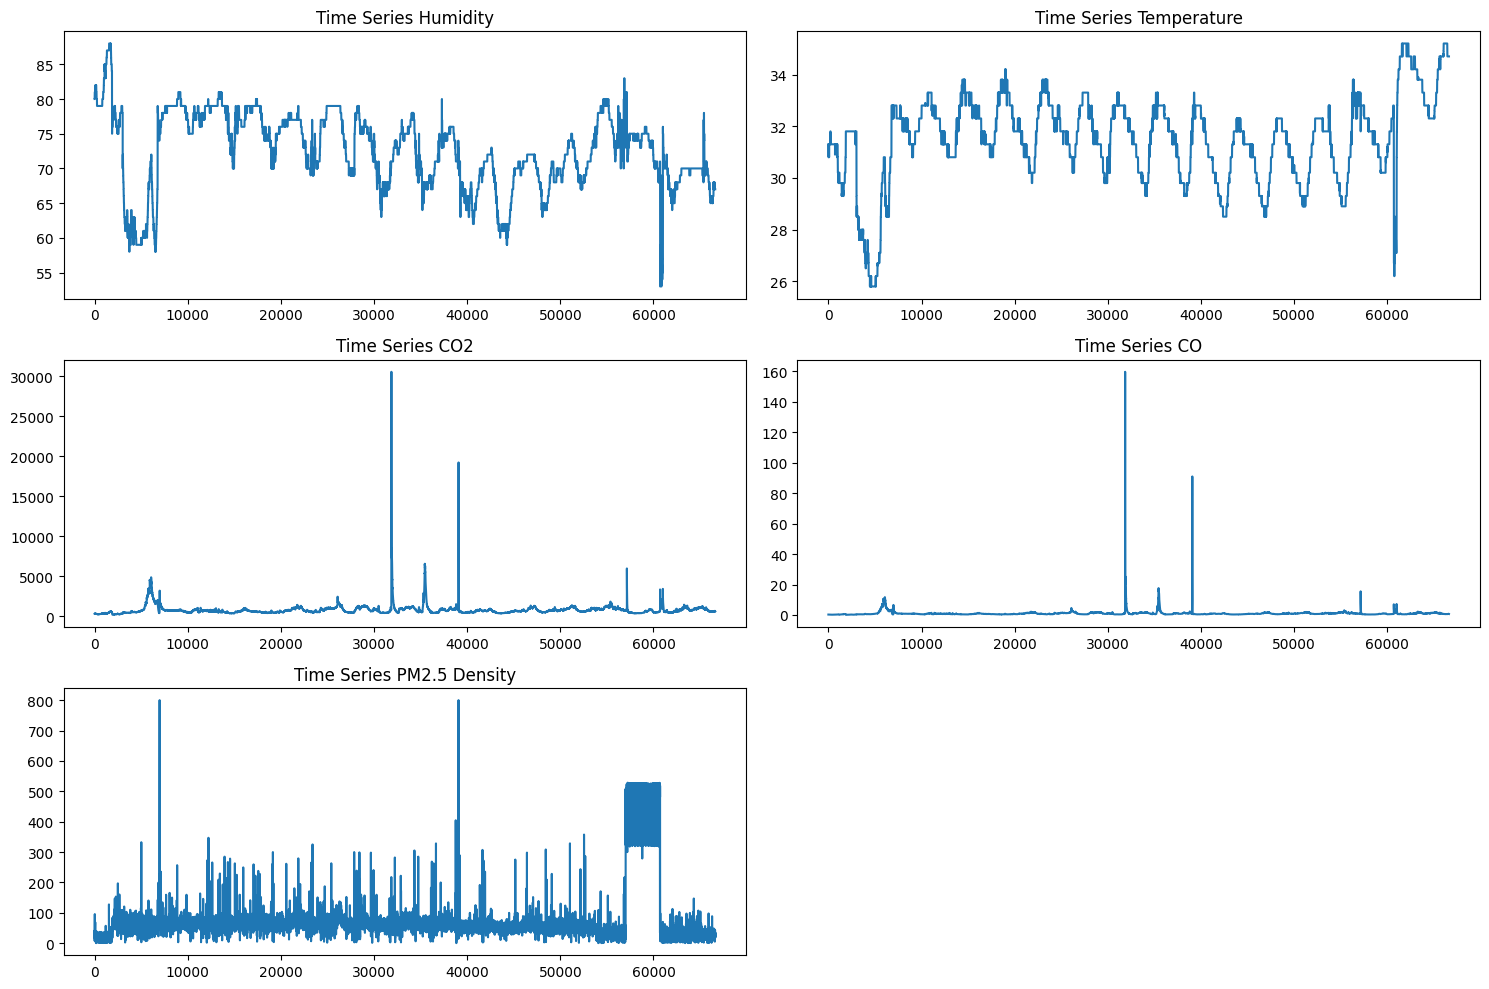

In [17]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    df[feature].plot()
    plt.title(f'Time Series {feature}')
plt.tight_layout()
plt.show()

#**2. Pre Processing Data**

##**2.1 Pengelompokan Data Menjadi Beberapa Kategori**

###**a. Pembuatan Kolom Kategori**

In [18]:
def calculate_aqi(concentration, breakpoints):
    for (ConcLow, ConcHigh, IndexLow, IndexHigh) in breakpoints:
        if ConcLow <= concentration <= ConcHigh:
            return ((IndexHigh - IndexLow) / (ConcHigh - ConcLow)) * (concentration - ConcLow) + IndexLow
    return None  # Jika nilai konsentrasi berada di luar rentang yang didefinisikan

def categorize_air_quality(row):
    pm25 = row['PM2.5 Density']
    co = row['CO']
    co2 = row['CO2']

    pm25_breakpoints = [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 350.4, 301, 400),
        (350.5, 500.4, 401, 500)
    ]

    co_breakpoints = [
        (0.0, 4.4, 0, 50),
        (4.5, 9.4, 51, 100),
        (9.5, 12.4, 101, 150),
        (12.5, 15.4, 151, 200),
        (15.5, 30.4, 201, 300),
        (30.5, 40.4, 301, 400),
        (40.5, 50.4, 401, 500)
    ]

    co2_breakpoints = [
        (0.0, 1000, 0, 50),
        (1001, 2000, 51, 100),
        (2001, 3000, 101, 150),
        (3001, 4000, 151, 200),
        (4001, 5000, 201, 300),
        (5001, 6000, 301, 400),
        (6001, 10000, 401, 500)
    ]

    pm25_aqi = calculate_aqi(pm25, pm25_breakpoints)
    co_aqi = calculate_aqi(co, co_breakpoints)
    co2_aqi = calculate_aqi(co2, co2_breakpoints)

    aqi_values = [value for value in [pm25_aqi, co_aqi, co2_aqi] if value is not None]

    if not aqi_values:
        return 'Tidak Tersedia'

    overall_aqi = max(aqi_values)

    if overall_aqi <= 100:
        return 'Baik'
    elif 101 <= overall_aqi <= 200:
        return 'Sedang'
    else:
        return 'Buruk'

df['Air Quality'] = df.apply(categorize_air_quality, axis=1)

print(df['Air Quality'].value_counts())

print(df.head())


Air Quality
Sedang            53371
Baik              10053
Buruk              2932
Tidak Tersedia        3
Name: count, dtype: int64
         Date and Time  Humidity  Temperature       CO2      CO  \
0  2024-07-03 22:20:12        80         31.3  320.7287  0.2814   
1  2024-07-03 22:20:32        80         30.8  322.3603  0.2834   
2  2024-07-03 22:20:52        80         30.8  317.3616  0.2774   
3  2024-07-03 22:21:12        80         30.8  315.5813  0.2753   
4  2024-07-03 22:21:32        80         30.8  313.0817  0.2724   

   PM2.5 Density Air Quality  
0        23.5440        Baik  
1        12.7967        Baik  
2        40.3489      Sedang  
3         7.5208        Baik  
4        22.1762        Baik  


###**b. Visualisasi Distribusi Kategori Data**

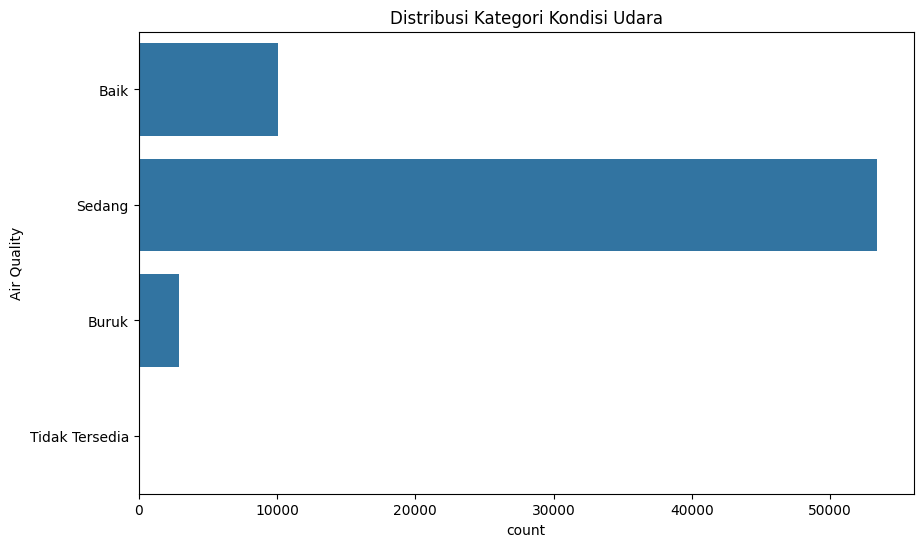

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(df['Air Quality'])
plt.title('Distribusi Kategori Kondisi Udara')
plt.show()

##**2.2 Mendefinisikan Fitur dan Target**

In [20]:
X = df[['Humidity', 'Temperature', 'CO2', 'CO', 'PM2.5 Density']]
y = df['Air Quality']

##**2.3 Membagi Data Menjadi Data Latih dan Uji**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##**2.4 Uji Asumsi Syarat Uji Klasifikasi**

###**a. Uji Keseimbangan Kelas**

In [22]:
# Pastikan distribusi label seimbang di data latih dan uji
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Air Quality
Sedang            0.804717
Baik              0.151506
Buruk             0.043740
Tidak Tersedia    0.000038
Name: proportion, dtype: float64
Air Quality
Sedang            0.802517
Baik              0.151447
Buruk             0.045961
Tidak Tersedia    0.000075
Name: proportion, dtype: float64


#**3. Pembangunan Model dan Uji Klasifikasi**

##**3.1 Pelatihan Model**

In [23]:
# Pelatihan Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

##**3.2 Evaluasi Model**

In [24]:
# Evaluasi model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.9996986136226642
Confusion Matrix:
 [[ 2010     0     0     0]
 [    0   609     1     0]
 [    0     3 10648     0]
 [    0     0     0     1]]
Classification Report:
                 precision    recall  f1-score   support

          Baik       1.00      1.00      1.00      2010
         Buruk       1.00      1.00      1.00       610
        Sedang       1.00      1.00      1.00     10651
Tidak Tersedia       1.00      1.00      1.00         1

      accuracy                           1.00     13272
     macro avg       1.00      1.00      1.00     13272
  weighted avg       1.00      1.00      1.00     13272



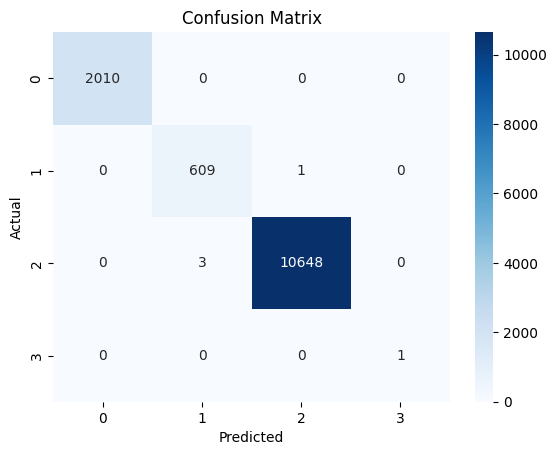

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##**3.3 Validasi Silang**

In [26]:
# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {cv_scores.mean()}')
print(f'Standard Deviation of CV Score: {cv_scores.std()}')

Cross-Validation Scores: [0.96323086 0.99977396 0.90159735 0.99992465 0.99909577]
Mean CV Score: 0.9727245192250262
Standard Deviation of CV Score: 0.038252232908307454


#**4. Hasil Prediksi dan Evaluasi**

In [27]:
new_data = pd.DataFrame({
    'Humidity': [60],
    'Temperature': [22],
    'CO2': [1500],
    'CO': [0.8],
    'PM2.5 Density': [30]
})

# Prediksi kualitas udara dengan data baru
new_prediction = model.predict(new_data)
print('Prediksi Kualitas Udara:', new_prediction[0])

new_prediction_proba = model.predict_proba(new_data)
print('Probabilitas Kategori:', new_prediction_proba)

Prediksi Kualitas Udara: Baik
Probabilitas Kategori: [[1. 0. 0. 0.]]
